In [1]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [2]:
import pandas as pd
df = pd.DataFrame({'A': [1, 2, 3, 4], 'B': [1, 2, 3, 4]})

from pandas_profiling import ProfileReport
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile.to_widgets()

C:\Users\roelv\AppData\Local\Temp\ipykernel_28040\3263590316.py:4: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [1]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from tqdm.notebook import tqdm
import time
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import kwant
import math
from math import  sqrt
import cmath
from numpy.lib.scimath import sqrt as csqrt
import scipy
from scipy.optimize import fsolve
import copy
from itertools import repeat

In [2]:
# Defining the Jordan Wigner transformation for a 1D lattice
def jordan_wigner_transform(j, lattice_length):
    operators = sigmaz()
    for _ in range(j-1): operators = tensor(operators, sigmaz())
    if j == 0:
        operators = sigmam()
    else:
        operators = tensor(operators, sigmam())
    for _ in range(lattice_length - j - 1): operators = tensor(operators, identity(2))
    return operators

# Define rho0 distribution
def Lorentzian(omega, Gamma, poles):
    Rho0 = Gamma / np.pi / (omega ** 2 + Gamma ** 2)
    p = np.random.uniform(0, 1, poles)
    return Rho0, np.array([Gamma * math.tan(np.pi * (p[i] - 1 / 2)) for i in range(len(p))])

# Calculates parameters impengergy,bathenergy and Vkk from random sampling distribution
def nonintG(omega, eta, select):
    G = 0
    for i, _ in enumerate(select): G += 1 / len(select) / (omega - select[i] + 1.j * eta)
    return G

def HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma):
    H = 0
    for i in range(2):
        H += impenergy * (c[i].dag() * c[i])
        for j in range(len(bathenergy)):
            H += Vkk[j] * (c[i].dag() * c[2 * j + i + 2] + c[2 * j + i + 2].dag() * c[i])
            H += bathenergy[j] * (c[2 * j + i + 2].dag() * c[2 * j + i + 2])
    error=False
    try:
        exp = np.dot(H.eigenstates()[1][0].dag(), np.dot(n, H.eigenstates()[1][0]))
    except np.linalg.LinAlgError or ValueError:
        error=True
        exp=0

    H += U * (c[0].dag() * c[0] * c[1].dag() * c[1])
    H += -Sigma * (c[0].dag() * c[0] + c[1].dag() * c[1])
    return H,exp,error

def MBGAIM2(omega, eigs, c, eta):
    MBG = np.zeros(len(omega),dtype = 'complex_')
    eigs2=copy.deepcopy(eigs[1])
    for i in range(len(eigs[1])):
        eigs2[i]=eigs2[i].dag()
    expA=np.reshape(eigs2,(len(eigs[1]),1))*c[0]*np.reshape(eigs[1],(1,len(eigs[1])))
    exp2A=np.reshape(eigs2,(len(eigs[1]),1))*c[0].dag()*np.reshape(eigs[1],(1,len(eigs[1])))
    for i in range(1, len(eigs[0])):
        #exp=np.dot(eigs[1][i].dag(),np.dot(c[0],eigs[1][0]))#m
        #exp2=np.dot(eigs[1][0].dag(),np.dot(c[0].dag(),eigs[1][i]))#i0
        #exp3=np.dot(eigs[1][i].dag(),np.dot(c[0].dag(),eigs[1][0]))
        #exp4=np.dot(eigs[1][0].dag(),np.dot(c[0],eigs[1][i]))#i0
        #k=exp[0][0]*exp2[0][0]
        #l=exp3[0][0]*exp4[0][0]
        exp=expA[i][0]
        exp2=exp2A[0][i]
        exp3=exp2A[i][0]
        exp4=expA[0][i]
        k=exp[0][0][0]*exp2[0][0][0]
        l=exp3[0][0][0]*exp4[0][0][0]
        final = k / (omega + eigs[0][i] - eigs[0][0] + 1.j * eta) + l / (omega + eigs[0][0] - eigs[0][i] + 1.j * eta)
        MBG += final
    return MBG

def MBGAIM(omega, eigs, c, eta):
    MBG = np.zeros(len(omega),dtype = 'complex_')
    for i in range(1, len(eigs[0])):
        exp = np.dot(eigs[1][i].dag(), np.dot(c[0], eigs[1][0]))
        exp2 = np.dot(eigs[1][i].dag(), np.dot(c[0].dag(), eigs[1][0]))
        k = abs(exp[0][0]) ** 2
        l = abs(exp2[0][0]) ** 2
        final = k / (omega + eigs[0][i] - eigs[0][0] + 1.j * eta) + l / (omega + eigs[0][0] - eigs[0][i] + 1.j * eta)
        MBG += final
    return MBG

# Gives Green’s function for the impurity level in the full interacting system (up and down spin)
def AIMsolver(impenergy, bathenergy, Vkk, U, Sigma, omega, eta, c,reset):
    MBG = np.zeros(len(omega),dtype = 'complex_')
    H,exp2,error = HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma)
    print("--- %s s first part %d---" % ((time.time() - start_time) ,attempts), end='\r')
    if not error:
        eigs=H.eigenstates()
        exp = np.dot(eigs[1][0].dag(), np.dot(n, eigs[1][0]))
        if np.round(exp)==np.round(exp2):
            reset=True
            print("--- %s s second part %d---" % ((time.time() - start_time) ,attempts), end='\r')
            MBG = MBGAIM(omega, eigs, c, eta)
        return MBG,reset
    else:
        return MBG,reset

def startrans(poles,select,row,omega, eta):
    di=np.full((poles-1, poles), np.zeros(poles))
    for i in range(poles-1):
        for j in (j for j in range(poles-1) if j>=i): di[i][j+1]=-1/sqrt((poles-i-1)*(poles-i))
        di[i][i]=sqrt(poles-i-1)/sqrt(poles-i)
    Pbath=np.insert(di, row,1/sqrt(poles),axis=0) 
    Dbath=np.zeros((poles,poles))
    for i in range(len(select)): Dbath[i][i]=select[i]
    ham_mat=np.dot(Pbath,np.dot(Dbath,Pbath.T))
    pbar=np.insert(np.insert(np.linalg.eig(np.delete(np.delete(ham_mat,row,axis=0),row,axis=1))[1], row,0,axis=0),row,0,axis=1)
    pbar[row][row]=1
    return np.dot(pbar.T,np.dot(ham_mat,pbar)),nonintG(omega, eta, select)

In [3]:
omega= np.linspace(-3,3,1001)
N=1000
poles=2
U=3
Sigma=U/2
Gamma=0.3
AvgSigmadat=np.zeros(len(omega),dtype = 'complex_')
AvgSigma=np.zeros(len(omega),dtype = 'complex_')
AvgSigmadat2=np.zeros(len(omega),dtype = 'complex_')
eta=0.02*abs(omega)+0.000000000000000000000001
c = []
for i in range(2+2*(poles-1)):
    c.append(jordan_wigner_transform(i, 2+2*(poles-1)))
n=0
for i in range(2+2*(poles-1)):
    n+=c[i].dag()*c[i]
Ntot=0
for i in tqdm(range(N)):
    start_time = time.time()
    attempts=0
    reset=False
    while not reset:
        NewM,nonG=startrans(poles,sorted(Lorentzian(omega, Gamma, poles)[1]),0,omega,eta)
        bathenergy=[]
        impenergy=NewM[0][0]
        for k in range(len(NewM)-1):
            bathenergy.append(NewM[k+1][k+1])
        Vkk=NewM[0,1:]

        MBGdat,reset=AIMsolver(impenergy, bathenergy, Vkk, U,Sigma,omega,eta,c,reset)
        NewSigmadat=1/nonG-1/MBGdat+Sigma
        if np.isnan(NewSigmadat).any() or any(i >= 1000 for i in np.real(NewSigmadat)):
            reset=False
        #else:
        #    Ntot+=1
        #    AvgSigmadat2=AvgSigmadat2+NewSigmadat
        attempts+=1
    AvgSigmadat=AvgSigmadat+NewSigmadat/N
    AvgSigma=AvgSigma+NewSigmadat
    #print(AvgSigmadat[500]/(i+1)*N, end='\r')
    #Sigma=np.real(AvgSigma[500])/(i+1)

  0%|          | 0/1000 [00:00<?, ?it/s]

(1.497468206019408-5.664265725349288e-24j)


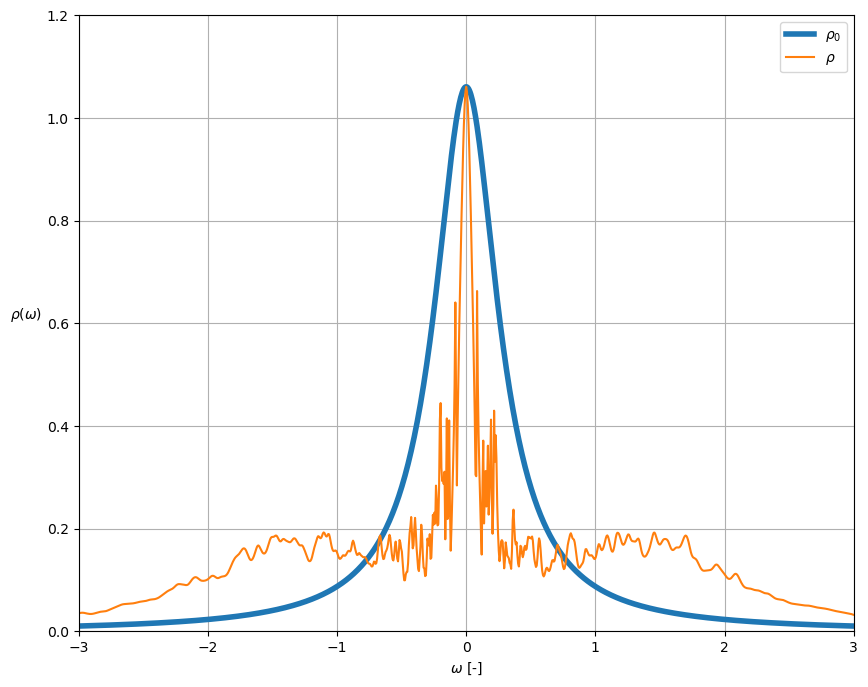

In [4]:
print(AvgSigmadat[500])
Ed=-AvgSigmadat[500]
finalG=np.nan_to_num(1/(omega-AvgSigmadat-Ed+1j*Gamma))
#finalG2=np.nan_to_num(1/(omega-AvgSigmadat2/Ntot+AvgSigmadat2[500]/Ntot+1j*Gamma))
fDOS=-np.imag(finalG)/np.pi
#fDOS2=-np.imag(finalG2)/np.pi
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=1.2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.plot(omega,Lorentzian(omega,Gamma,poles)[0],linewidth=4,label='$\\rho_0$')
plt.plot(omega, fDOS,label='$\\rho$')
#plt.plot(omega, fDOS2,label='$\\rho$')
plt.legend()
plt.grid()
plt.savefig('DOS_AIM030ncv2.png')

In [7]:
FinSigmadat2=[omega,fDOS]

np.savetxt('DOS_AIM030ncv3',np.transpose(FinSigmadat2), fmt='%.18g', delimiter='\t', newline='\n')
text_file = open("DOS_AIM030ncv3", "r")
lines = text_file.read().split('\n')
print(lines[0])
for i in range(len(lines)-1):
    lines[i]=lines[i].split('\t')
    for j in range(2):
        lines[i][j]=float(lines[i][j])
print(lines)
text_file.close()

-3	0.0305463873911944982
[[-3.0, 0.030546387391194498], [-2.994, 0.031003869809652466], [-2.988, 0.03142265387596142], [-2.982, 0.0317876635709122], [-2.976, 0.03208829666644983], [-2.97, 0.032322708503060404], [-2.964, 0.0325002263727852], [-2.958, 0.03264048661552191], [-2.952, 0.032769374191300764], [-2.946, 0.032913322017356965], [-2.94, 0.03309396343993394], [-2.934, 0.03332443999484904], [-2.928, 0.033607622250568514], [-2.922, 0.03393588247368902], [-2.916, 0.03429209897531452], [-2.91, 0.03465200416405368], [-2.904, 0.03498827853908152], [-2.898, 0.03527641821775458], [-2.892, 0.03550127548236001], [-2.886, 0.03566201506375284], [-2.88, 0.0357732518779816], [-2.874, 0.03586180962655626], [-2.868, 0.03596075476245541], [-2.862, 0.03610337498639525], [-2.856, 0.03631902802917838], [-2.85, 0.03663128256065111], [-2.844, 0.03705774404631723], [-2.838, 0.03761076532440255], [-2.832, 0.03829850951163757], [-2.826, 0.0391261245731548], [-2.82, 0.04009692585910945], [-2.814, 0.04121346